In [2]:
import numpy as np
import pandas as pd
import emcee
import corner
from scipy.optimize import minimize
from multiprocessing import Pool
import time
import matplotlib.pyplot as plt

In [3]:
%matplotlib notebook

In [4]:
sn = 'ZTF18abqbavl'
lc_df = pd.read_hdf("../../forced_lightcurves/sample_lc_v2/{}_force_phot.h5".format(sn))
salt_df = pd.read_csv("../../Nobs_cut_salt2_spec_subtype.csv")

In [5]:
lc_df.head()

,jdobs,filter,seeing,gain,zp,ezp,programid,fieldid,ccdid,qid,...,Fmcmc,Fmcmc_unc,Fratio,Fratio_unc,jdref_start,jdref_end,fcqfid,scisigpix,offset,multiply
0,2.458208e+06,b'g',2.010,5.843234,26.325,0.000008,2.0,723.0,9.0,2.0,...,-63.442286,51.683403,-1.872315e-09,1.525285e-09,2.458204e+06,2.458207e+06,7230921.0,14.1645,5.866686,0.979593
1,2.458208e+06,b'g',2.054,5.896401,26.325,0.000010,2.0,723.0,9.0,2.0,...,-13.639000,52.987672,-4.025154e-10,1.563777e-09,2.458204e+06,2.458207e+06,7230921.0,13.4468,5.866686,0.979593
2,2.458208e+06,b'g',1.937,5.958763,26.325,0.000009,2.0,723.0,9.0,2.0,...,105.884436,42.314585,3.124871e-09,1.248792e-09,2.458204e+06,2.458207e+06,7230921.0,13.0818,5.866686,0.979593
0,2.458208e+06,b'g',1.799,5.963531,26.325,0.000008,1.0,723.0,9.0,2.0,...,8.460568,41.599798,2.496891e-10,1.227697e-09,2.458204e+06,2.458207e+06,7230921.0,13.0194,5.866686,0.979593
3,2.458208e+06,b'g',1.791,6.034095,26.325,0.000008,2.0,723.0,9.0,2.0,...,-21.299965,39.310110,-6.286065e-10,1.160124e-09,2.458204e+06,2.458207e+06,7230921.0,12.2698,5.866686,0.979593


<IPython.core.display.Javascript object>


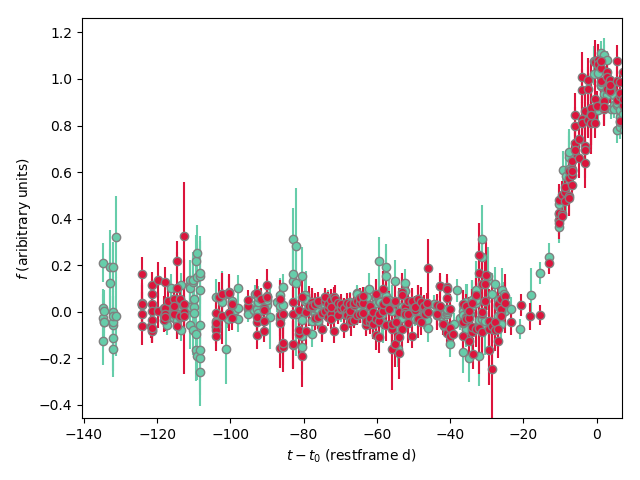

There are 545 obs before half max


In [6]:
g_obs = np.where( (lc_df['offset'] > -9999) & 
                 (lc_df['filter'] == b'g'))
r_obs = np.where( (lc_df['offset'] > -9999) & 
                 (lc_df['filter'] == b'r'))
obs = np.where(  (lc_df['offset'] > -9999)  
              )

t0 = float(salt_df['t0_g_adopted'][salt_df['name'] == sn].values)
z = float(salt_df['z_adopt'][salt_df['name'] == sn].values)
g_max = float(salt_df['fratio_gmax_2adam'][salt_df['name'] == sn].values)
r_max = float(salt_df['fratio_rmax_2adam'][salt_df['name'] == sn].values)

N_r = len(np.where((lc_df['Fratio'].iloc[r_obs]/np.max(lc_df['Fratio'].iloc[r_obs]) < 0.5) & 
                   ((lc_df['jdobs'].iloc[r_obs] - t0)/(1+z) < 0))[0])
N_g = len(np.where((lc_df['Fratio'].iloc[g_obs]/np.max(lc_df['Fratio'].iloc[g_obs]) < 0.5) & 
                   ((lc_df['jdobs'].iloc[g_obs] - t0)/(1+z) < 0))[0])


fig, ax = plt.subplots()
ax.errorbar((lc_df['jdobs'].iloc[g_obs] - t0)/(1+z), 
            lc_df['Fratio'].iloc[g_obs]/g_max,
            lc_df['Fratio_unc'].iloc[g_obs]/g_max, 
            fmt = 'o', color='MediumAquaMarine',
            mec='0.5')
ax.errorbar((lc_df['jdobs'].iloc[r_obs] - t0)/(1+z), 
            lc_df['Fratio'].iloc[r_obs]/r_max,
            lc_df['Fratio_unc'].iloc[r_obs]/r_max, 
            fmt = 'o', color='Crimson',
            mec='0.5')
ax.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
ax.set_ylabel('$f \; (\mathrm{aribitrary \; units})$')
fig.tight_layout()

print('There are {} obs before half max'.format(N_g + N_r))

In [16]:
def f_t(times, amplitude=25, t_0=0, alpha_r=2):
    
    return amplitude * (times - t_0)**alpha_r

def plot_model(t, f, f_unc, theta):
    half_max = np.where((f < 0.5) & (t < 0))
    
    t_post = np.linspace(theta[0], 80, 1000)
    t_pre = np.linspace(min(t), theta[0], 1000)
    model_flux = theta[1] + f_t(t_post, theta[2], theta[0], theta[3])
    fig = plt.figure()
    axPlot = plt.axes([0.15, 0.37, 0.82, 0.61])
    axRes = plt.axes([0.15, 0.1, 0.82, 0.25], sharex=axPlot)
    axPlot.errorbar(t, f, f_unc,
                fmt = 'o', color='MediumAquaMarine',
                mec='0.5')
    axPlot.plot(t_post, model_flux, 'k', zorder=10)
    axPlot.plot(t_pre, np.ones_like(t_pre)*theta[1], 'k', zorder=10)
    axPlot.plot([max(t[half_max]),max(t[half_max])], [-50,50], 
               '--', color='DarkOrange')
    axPlot.set_xlim(min(t), 3)
    axPlot.set_ylim(min(f), 1.1)

    after_exp = t >= theta[0]
    
    residuals = np.append(f[~after_exp] - theta[1], 
                          f[after_exp] - (theta[1] + f_t(t[after_exp], theta[2], theta[0], theta[3]))  
                         )
    
    axRes.errorbar(t, residuals, f_unc,
                   fmt = 'o', color='MediumAquaMarine',
                   mec='0.5')
    axRes.plot([-5000,10000], [0,0], 'k--')
    axRes.plot([max(t[half_max]),max(t[half_max])], [-50,50], 
               '--', color='DarkOrange')
    axRes.set_xlim(min(t), 3)


    axRes.set_ylim(min(residuals[half_max]), max(residuals[half_max]))
    axRes.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
    axPlot.set_ylabel('$f \; (\mathrm{aribitrary \; units})$')
#     fig.tight_layout()
    
    return

def plot_both_filt(theta, t, f, f_unc, filt_arr,
                   t0=-18):

    color_dict = {b'r': 'Crimson',
                  b'g': 'MediumAquaMarine'}
    offset_dict = {b'r': -0.1,
                  b'g': 0.1}
    mark_color_dict = {b'r': 'white',
                  b'g': 'MediumAquaMarine'}
    sym_dict = {b'r': 'o',
                b'g': 'o'}
    mec_dict = {b'r': 'Crimson',
                b'g': '0.5'}
    mew_dict = {b'r': 2,
                b'g': 0.5}
    
    if len(theta) % 3 != 1:
        raise RuntimeError('The correct number of parameters were not included')

    fig = plt.figure()
    axPlot = plt.axes([0.15, 0.37, 0.82, 0.61])
    axRes = plt.axes([0.15, 0.1, 0.82, 0.25], sharex=axPlot)

    for filt_num, filt in enumerate(np.unique(filt_arr)):
        theta_filt = np.append(theta[0], theta[1+3*filt_num:4+3*filt_num])
        filt_obs = np.where(filt_arr == filt)
        f_filt = f[filt_obs]
        t_filt = t[filt_obs]
        f_err_filt = f_unc[filt_obs]

        cutoff = ((f_filt < 0.5) & (t_filt < 0))
        t_cut = t_filt[cutoff][-1] + 0.5
        half_max = (t_filt <= t_cut)
    
        t_post = np.linspace(theta[0], 80, 1000)
        t_pre = np.linspace(min(t_filt), theta[0], 1000)
        model_flux = theta_filt[1] + f_t(t_post, theta_filt[2], theta_filt[0], theta_filt[3])

        axPlot.errorbar(t_filt[half_max], f_filt[half_max] + offset_dict[filt], f_err_filt[half_max],
                    fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                    mec=mec_dict[filt], mew=mew_dict[filt])
        axPlot.errorbar(t_filt[~half_max], f_filt[~half_max] + offset_dict[filt], f_err_filt[~half_max],
                    fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                    mec=mec_dict[filt], mew=mew_dict[filt], alpha=0.2)
        axPlot.plot(t_post, model_flux + offset_dict[filt], color=color_dict[filt], zorder=10)
        axPlot.plot(t_pre, np.ones_like(t_pre)*theta_filt[1] + offset_dict[filt], color=color_dict[filt], zorder=10)
#         axPlot.plot([max(t_filt[half_max]),max(t_filt[half_max])], [-50,50], 
#                    '--', color=color_dict[filt])
        axPlot.set_xlim(-30, 3)
        axPlot.set_ylim(min(f_filt[half_max])-0.15, 1.2)
#         axPlot.set_xticklabels([])

        after_exp = t_filt >= theta_filt[0]

        residuals = np.append(f_filt[~after_exp] - theta_filt[1], 
                              f_filt[after_exp] - (theta_filt[1] + f_t(t_filt[after_exp], theta_filt[2], theta_filt[0], theta_filt[3]))  
                             )

        axRes.errorbar(t_filt[half_max], residuals[half_max] + offset_dict[filt], f_err_filt[half_max],
                       fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                       mec=mec_dict[filt], mew=mew_dict[filt])
        axRes.errorbar(t_filt[~half_max], residuals[~half_max] + offset_dict[filt], f_err_filt[~half_max],
                       fmt = sym_dict[filt], color=mark_color_dict[filt], ecolor=color_dict[filt],
                       mec=mec_dict[filt], mew=mew_dict[filt], alpha=0.2)
        axRes.plot([-5000,10000], [offset_dict[filt], offset_dict[filt]], '-', color=color_dict[filt])
#         axRes.plot([max(t_filt[half_max]),max(t_filt[half_max])], [-50,50], 
#                    '--', color=color_dict[filt])
        axRes.set_xlim(-30, 3)
        axRes.set_ylim(min(residuals[half_max]) - 0.1, max(residuals[half_max]) + 0.1)
        axRes.set_xlabel('$t - t_0 \; (\mathrm{restframe \; d})$')
        axPlot.set_ylabel('$f \; (\mathrm{aribitrary \; units})$')

    if t0 != -18:
        axPlot.plot([t0,t0], [-50,50], 
               '--', color='0.8', lw=0.5)
        axRes.plot([t0,t0], [-50,50], 
               '--', color='0.8', lw=0.5)

    return

In [9]:
def lnlike_simple(theta, f, t, f_err):
    t_0, a, a_prime, alpha_r = theta
    
    pre_exp = np.logical_not(t > t_0)
    model = np.empty_like(f)
    model[pre_exp] = a
    
    time_term = (t[~pre_exp] - t_0)
    model[~pre_exp] = a + a_prime * (time_term)**alpha_r
    
    ln_l = -0.5*np.sum((f - model)**2 / (f_err**2))
    return ln_l

def nll_simple(theta, f, t, f_err):
    return -1*lnlike_simple(theta, f, t, f_err)

#Define priors on parameters  
def lnprior_simple(theta):
    t_0, a, a_prime, alpha_r = theta
    if (-1e8 < t_0 < 1e8 and 0 < alpha_r < 1e8 and 
        -1e8 < a < 1e8 and 
        0 < a_prime < 1e8):
        return 0.0
    return -np.inf

def lnposterior_simple(theta, f, t, f_err):
    lnp = lnprior_simple(theta)
    lnl = lnlike_simple(theta, f, t, f_err)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp

## Fit multiple filters for $t_\mathrm{fl}$ and $\alpha_r$

In [12]:
def multifilter_lnlike_simple(theta, f, t, f_err, filt_arr):
    
    if len(theta) % 3 != 1:
        raise RuntimeError('The correct number of parameters were not included')
    
    ln_l = 0
    for filt_num, filt in enumerate(np.unique(filt_arr)):
        theta_filt = np.append(theta[0], theta[1+3*filt_num:4+3*filt_num])
        filt_obs = np.where(filt_arr == filt)
        f_filt = f[filt_obs]
        t_filt = t[filt_obs]
        f_err_filt = f_err[filt_obs]
        ln_l += lnlike_simple(theta_filt, f_filt, t_filt, f_err_filt)
    
    return ln_l

def multifilter_nll_simple(theta, f, t, f_err, filt_arr):
    return -1*multifilter_lnlike_simple(theta, f, t, f_err, filt_arr)

def multifilter_lnprior_simple(theta, filt_arr):
    
    if len(theta) % 3 != 1:
        raise RuntimeError('The correct number of parameters were not included')
    
    ln_p = 0
    for filt_num, filt in enumerate(np.unique(filt_arr)):
        theta_filt = np.append(theta[0], theta[1+3*filt_num:4+3*filt_num])
        ln_p += lnprior_simple(theta_filt)
    return ln_p

def multifilter_lnposterior_simple(theta, f, t, f_err, filt_arr):
    lnp = multifilter_lnprior_simple(theta, filt_arr)
    lnl = multifilter_lnlike_simple(theta, f, t, f_err, filt_arr)
    if not np.isfinite(lnl):
        return -np.inf
    if not np.isfinite(lnp):
        return -np.inf
    return lnl + lnp

In [13]:
obs = np.where( (lc_df['offset'] > -999)  
              )

g_obs = np.where(lc_df.iloc[obs]['filter'] == b'g')
r_obs = np.where(lc_df.iloc[obs]['filter'] == b'r')

time_rf = (lc_df['jdobs'].iloc[obs].values - t0)/(1+z)
flux = lc_df['Fratio'].iloc[obs].values
flux[g_obs] = flux[g_obs]/g_max
flux[r_obs] = flux[r_obs]/r_max
flux_unc = lc_df['Fratio_unc'].iloc[obs].values
flux_unc[g_obs] = flux_unc[g_obs]/g_max
flux_unc[r_obs] = flux_unc[r_obs]/r_max
filt_arr = lc_df['filter'].iloc[obs].values


t_fl = 18

guess_0 = [-t_fl, 
           0, 6e-3, 2,
           0, 6e-3, 2
          ]

half_max_g = np.where((flux[g_obs] < 0.5) & (time_rf[g_obs] < 0))
early_obs = np.where(time_rf <= time_rf[g_obs][np.max(half_max_g[0])])

f_data = flux[early_obs]
t_data = time_rf[early_obs]
f_unc_data = flux_unc[early_obs]
filt_data = filt_arr[early_obs]

print(multifilter_nll_simple(guess_0, flux, time_rf, flux_unc, filt_arr))

75653682.08515829


In [14]:
# initialize near maximum-likelihood result
ml_res = minimize(multifilter_nll_simple, guess_0, method='Powell', # Powell method does not need derivatives
                  args=(f_data, t_data, f_unc_data, filt_data))
ml_guess = ml_res.x
print(ml_guess)
print(multifilter_nll_simple(ml_guess, f_data, t_data, f_unc_data, filt_data))

[-2.04754799e+01  1.38583667e-02  5.39680634e-03  1.84275804e+00
  3.08951877e-03  3.23851022e-03  2.04305933e+00]
255.12808629095315


<IPython.core.display.Javascript object>


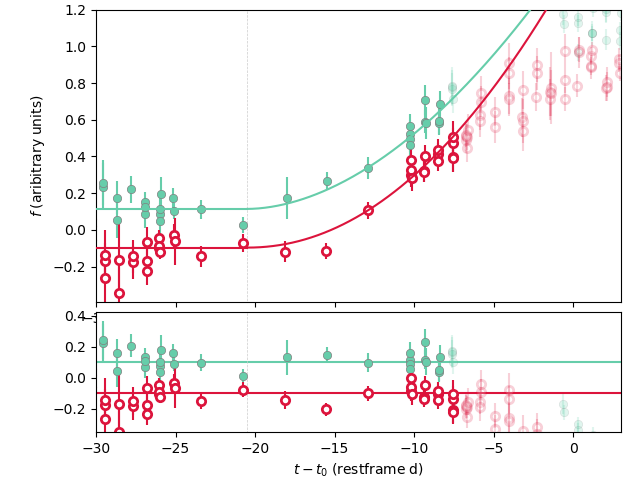

In [18]:
plot_both_filt(ml_guess, time_rf, flux, flux_unc, filt_arr, t0=ml_guess[0])

In [32]:
#define funtion to make corner plot
def makeCorner(sampler, nburn, paramsNames, quantiles=[0.16, 0.5, 0.84], truths=[]):
    samples = sampler.get_chain(discard=nburn, flat=True)
    if len(truths) > 0:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          truths=truths, plot_datapoints=False)
    else:
        f = corner.corner(samples, labels = paramsNames, quantiles = quantiles, 
                          show_titles=True, plot_datapoints=False)
    
#define function to plot walker chains  
def plotChains(sampler, nburn, paramsNames, nplot=nwalkers):
    Nparams = len(paramsNames)
    fig, ax = plt.subplots(Nparams+1,1, figsize = (8,2*(Nparams+1)), sharex = True)
    fig.subplots_adjust(hspace = 0)
    ax[0].set_title('Chains')
    xplot = np.arange(sampler.get_chain().shape[0])

    selected_walkers = np.random.choice(range(sampler.get_chain().shape[1]), nplot, replace=False)
    for i,p in enumerate(paramsNames):
        for w in selected_walkers:
            burn = ax[i].plot(xplot[:nburn], sampler.get_chain()[:nburn,w,i], 
                              alpha = 0.4, lw = 0.7, zorder = 1)
            ax[i].plot(xplot[nburn:], sampler.get_chain(discard=nburn)[:,w,i], 
                       color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
            
            ax[i].set_ylabel(p)
            if i==Nparams-1:
                ax[i+1].plot(xplot[:nburn], sampler.get_log_prob()[:nburn,w], 
                             color=burn[0].get_color(), alpha = 0.4, lw = 0.7, zorder = 1)
                ax[i+1].plot(xplot[nburn:], sampler.get_log_prob(discard=nburn)[:,w], 
                             color=burn[0].get_color(), alpha = 0.8, lw = 0.7, zorder = 1)
                ax[i+1].set_ylabel('ln P')
            
    return ax

paramsNames=[r'$t_\mathrm{fl}$', 
             '$a_g$', r"$A'_g$", r'$\alpha_{r, g}$']
gr_paramsNames=[r'$t_\mathrm{fl}$', 
             '$a_g$', r"$A'_g$", r'$\alpha_{r, g}$', 
             '$a_r$', r"$A'_r$", r'$\alpha_{r, r}$']
